# Project 10: Energy transport on a grid
Jannek Schaffert - Lecture Classical Complex Systems WS 24/25

<div class="alert alert-block alert-info">
<b>Disclaimer:</b> I adopted some code from previous exercises. Therefore there are a couple of remenants of that code can still to be found in this code. Most notably the class-system. All new code implemented for this task is found in the Froggy-class (sorry for the name, that was work in progress which I don't want to change, because frogs are cute). However I am going to briefly explain this code as well, but not in as much detail as the Froggy-class. All of the code is commented as well and hopefully understandable even tough sometimes I used a non-obvious way of implementation.</div>

##### Imports
Mainly numpy is used for faster array operations. Additionally some modules from matplotlib are imported for visualization purposes and tqdm for progress visualization of for-loops.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization

import numpy as np


#### The Class-System
Initially a brief explanation of the class system used, before diving deeper into the implementation and topic.
At some point I had to recycle so much code from different exercises, that I choose to implement a base-class Box(), which is the parent to many sub-classes implementing the different molecular dynamics simulations (HardSpheres, LennardJones, Infection, etc...). This class contains some variables and functions used in all other classes as well. Primarily all natural constants, the box size, the position/velocity/acceleration/mass/radius of particles and a random number Generator for reproducible results. Additionally it contains a variable showing the current temperature of the particles in the box.
The functions contained in the box-class are as follows:

def \__init__(self, box_size, rng_seed:int|None=None):   When initializing the class, the box size in nm is expected. Additional parameter is an rng_seed used for the standard numpy Generator.

def \__repr__(self):     When printing, gives some information about the object

def set_rng(self, rng_seed:int|None=None) -> None:  Sets the random Generator. Can be called to e.g. reset the Generator

def empty_arrays(self, pos:bool = True, vel:bool = True, acc:bool = True, radius:bool = True, mass:bool = True) -> None:    Used to allocate some memory for the arrays used. Or to reset the arrays. All arguments can be set to False in order to not (re)set them.

def random_positions(self, axis, n_particles = 0) -> None:  A helper function to give random positions along one axis (either x or y).

def fixedtemp_velocities(self, target_temp):    Another helper function to give velocities that together form an ensemble of a specified target temperature.

def fill_particles(self, n_Particles:int, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp:float = 300) -> None:    A way of filling the box with particles. n_Particles is the number of particles that should be filled. radius is the radii of the particles, either as an array of length n_Particles or as an int/float for equal radii. The same is true for mass. vel is the absolute velocities of the particles, again either as an array of all velocitites or as a number for equal velocities. Can also be a string in order to get velocities that form an ensemble of a specified target temperature (passed as target_temp, kinda a weird way, I know). angle contains the angles at which each particles velocity is starting, can also be left empty for random angles. x and y contain the different x and y coordinates of all particles (only relevant if align is set to 'defined'). align can be set to different values ('random', 'grid', 'left-grid','defined'), random gives random positions, grid aligns all particles in a grid, based on the grid argument, similarly for left-grid, but the grid is contained to the left side of the box. All positions, velocities, etc... are stored in variables inside the object.

def move(self, dt:float = 1.0, vel = [], particles = []) -> None:   Moves all or part of the particles. dt indicates the time-step which is performed, vel can be given as an array for all particles, if left empty, the current velocities are used. particles specifies the particles to be moved, if left empty all are moved.

def wrap_around(self) -> None:  wraps around the particles if their positions are outside of the box boundaries

def calculate_kinEnergy_matrix(self) -> None:   calculates the current kinetic energy of each particle and stores it in an array.

This gives a basic implementation of a box for child classes to be used.

In [2]:
class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, rng_seed:int|None=None):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        rng_seed    : Random Number Generator seed for reproducible results. None for random seed.
        """
        # number of particles
        # self.n_particles = n_Particles
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol
        # The size of the box
        self.box_size       = box_size  # nm x nm
        # Setting the rng Generator
        self.rng_seed = rng_seed
        self.set_rng(self.rng_seed)
        # The  current temperatur of the entire system
        self.temp:float         = 0.    # K

    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")
    


    def set_rng(self, rng_seed:int|None=None) -> None:
        """Used to (re)set the rng Generator. The standard numpy Generator is used.
        From the documentation: PCG-64 is a 128-bit implementation of O'Neill's permutation congruential generator.\n
        rng_seed    : A seed to initialize the BitGenerator. If None, then fresh, unpredictable entropy will be pulled from the OS.
        """
        self.rng = np.random.default_rng(seed=rng_seed)

    def empty_arrays(self, pos:bool = True, vel:bool = True, acc:bool = True, radius:bool = True, mass:bool = True) -> None:
        """Initialize or Reset specific or all arrays to zero. Arguments are which arrays to reinitialize."""
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        if pos:
            self.particles_pos  = np.zeros((self.n_particles,2), dtype=float) # shape (n,2)
        if vel:
            self.particles_vel  = np.zeros((self.n_particles,2), dtype=float) # shape (n,2)
        if acc:
            self.particles_acc  = np.zeros((self.n_particles,2), dtype=float) # shape (n,2)

        # All of the radii stored in an array
        # Additionally the combined raddii are calculated for each pair
        if radius:
            self.particles_r    = np.zeros(self.n_particles, dtype=float)
            self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:] # shape (n,n)

        # All of the masses are stored in an array
        if mass:
            self.particles_m    = np.zeros(self.n_particles, dtype=float)
        
        




    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
        self.temp = target_temp
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, n_Particles:int, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp:float = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        self.n_particles = n_Particles
        self.grid        = grid
        # initialze all empty arrays
        self.empty_arrays()
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass
            
        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)

        
        
        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        """
        Check which alignment method should be choosen and fill the positions accoringly
        """
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)
        elif align == 'grid':
            if np.prod(self.grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.01 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                border_distance = self.box_size/self.grid/2
                print(border_distance)
                if np.any(border_distance < np.max(self.particles_r)): # makes sense??
                    print('WARNING: Particles overlapping!')
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0],num=self.grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1],num=self.grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + border_distance # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'left-grid':
            if np.prod(self.grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally, the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                border_distance = self.box_size/self.grid/2
                print(border_distance)
                if np.any(border_distance < np.max(self.particles_r)):
                    print('WARNING: Particles overlapping!')
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]/2,num=self.grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1],num=self.grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + border_distance # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        
        
        
        
        

    def move(self, dt:float = 1.0, vel = [], particles = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt          : the time-step moving forward; default = 1\n
        vel         : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        particles   : The particles that should be moved as indices for the position array of this class; default(empty) = all particles
        """
        if len(particles) == 0:
            if len(vel) == 0:
                vel = self.particles_vel
            self.particles_pos += vel*dt
        else:
            if len(vel) == 0:
                vel = self.particles_vel[particles]
            self.particles_pos[particles] += vel*dt

    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size


    def calculate_kinEnergy_matrix(self) -> None:
        """Calculate the current kinetic energy in the system."""
        self.kinEnergy_mat = 0.5 * self.particles_m * np.square(np.linalg.norm(self.particles_vel, axis=-1)) # shape: (n) #could be optimized maybe? square of squareroot of squares




#### The Froggy-Class
This class implements the energy transfer on a grid with a velocity verlet integrator. The potentials are derived from harmonic oscillators between neighbouring particles, which I'll describe in more detail in an upcoming section concerning the theory. Here I'll explain the theory of implementation. Many things are used from the parent class (Box()) explaine above, however one notable change is the reshaping of most arrays concerning the particles. For instance the array of particles postions is now in grid form of shape $(i x j x 2)$, with $i$ being the amount of particles on the grid in $x$-direction and $j$ in $y$-direction. This helps calculating the force and potential energy between each particle pair. This calculation is done for all neighbouring particles, however there are only $2n$ unique connections. Other connections are the same but in opposite direction. So the connection from one particle to its upper neighbourgh is the same as from the upper particle to the lower neighbourgh. I therefore only calculate the distance from each particle to its upper and right neighbourgh. 

In order to account for periodic boundaries, we append a ghost particle, mirroring the left/bottom most particles to the right/top, when calculating the distances to the right/top particle with np.diff(), since np.diff() does not allow for periodic boundaries. This is all done in the first line of the function calculate_frog_field(:). After that we can use the directional vectors to calculate the norm and with both the force that each harmonic oscillator acts on its particles. When combining all four forces for each particle, a special care needs to be put on the sign of the forces. All forces are directed either in the top or right direction. So when using np.roll() to get the next force to the bottom or left, we have to add that with a minus sign to account for the opposite direction. This is not necessary for the potential, since that has no direction.

The velocity verlet algorithm is implemented identically to previous exercises, with the formulas given. This will not be discussed here again.

In [3]:
class Froggy(Box):
    def __init__(self, box_size, rng_seed: int | None = None):
        super().__init__(box_size, rng_seed)

        
    
    def fill_particles(self, n_Particles, radius, mass, vel, omega, angle=[], x=[], y=[], align='random', grid = np.zeros(2, dtype=int), target_temp: float = 300) -> None:
        super().fill_particles(n_Particles, radius, mass, vel, angle, x, y, align, grid, target_temp)

        if type(omega) == int or type(vel) == float:
            self.omegax = np.ones((2,grid[0],grid[1]), dtype=float)*omega
        else:
            self.omegax = omega
        # reshape the arrays for easier calculation of the forces acting on each particle
        self.particles_pos = self.particles_pos.reshape((self.grid[0], self.grid[1], 2))
        self.particles_vel = self.particles_vel.reshape((self.grid[0], self.grid[1], 2))
        self.particles_acc = self.particles_acc.reshape((self.grid[0], self.grid[1], 2))
        self.particles_m    = self.particles_m.reshape((self.grid[0], self.grid[1]))

        
        
    
    
    def empty_arrays(self, 
                     pos: bool = True, 
                     vel: bool = True, 
                     acc: bool = True, 
                     radius: bool = True, 
                     mass: bool = True, 
                     force: bool = True, 
                     potE: bool = True, 
                     kinE: bool = True
                     ) -> None:
        super().empty_arrays(pos, vel, acc, radius, mass)
        # Storing the energy types currently in the system
        if force:
            self.force_mat      = np.zeros((self.n_particles,2), dtype=float)
        if potE:
            self.potE_mat      = np.zeros((self.n_particles), dtype=float)
        if kinE:
            self.kinEnergy_mat      = np.zeros((self.n_particles), dtype=float)




    def calculate_frog_field(self, r_0, verbose:bool = False) -> None:
        """This function calculates the force field and potential energy field.\n
        r_0     : parameter at which distance of two particles the potential is zero.\n
        verbose : Wether debug print commands are on.
        """
        # Only calculate the distances to the right and lower particle. 
        distances = np.array([np.diff(self.particles_pos, append=self.particles_pos[:,0, np.newaxis,:]+np.array([0,self.grid[0]]), axis=1), #
                              np.diff(self.particles_pos, append=self.particles_pos[0, np.newaxis,:,:]+np.array([self.grid[0],0]), axis=0)])#%self.box_size    
        
        # calculate the norm for later use
        norm = np.linalg.norm(distances, axis=-1)
        # calculate the directional force in the right and top direction, the direction needs to be swapped when viewed from the other particle
        directional_f = (self.omegax * (norm-(r_0)))[:,:,:,np.newaxis] * distances/(norm[:,:,:,np.newaxis])
        
        # add together all 4 forces from neighbouring particles. Using np.roll() and a negative sign to get all the correct forces acting on one particle
        self.force_mat = directional_f[0] + directional_f[1] - np.roll(directional_f[0], 1, axis=1) - np.roll(directional_f[1], 1, axis=0)

        # Do the same only for the potential energy of each particle
        directional_pot = (self.omegax * np.square(norm-(r_0)))
        # This time there is no minus signs, since the potential is not directional
        self.potE_mat  = directional_pot[0] + directional_pot[1] + np.roll(directional_pot[0], 1, axis=1) + np.roll(directional_pot[1], 1, axis=0)
        # print everything for debugging if verbose=True
        if verbose:
            print('particles_pos: ', self.particles_pos)
            print('distances: ', distances)
            print('directional_u: ', directional_f)
            print('pot_energy_mat: ', self.force_mat)



    def update_pos(self, dt) -> None:
        """Updates the position according to the velocity-verlet algorithm\n
        dt  : The time step used
        """
        self.particles_pos = self.particles_pos + self.particles_vel*dt + 1/2*(self.particles_acc*dt**2)
        # always wrap around...
        self.wrap_around()
    
    def update_vel_acc(self, dt) -> None:
        """Updates the velocities according to the velocity-verlet algorithm. Therefore the updated accelerations are needed.\n
        dt  : The time step used
        """
        new_acc = self.calculate_acc()
        self.particles_vel = self.particles_vel + 0.5*(self.particles_acc + new_acc)*dt
        self.particles_acc = new_acc

    def calculate_acc(self):
        """Updates the accelerations according to the velocity-verlet algorithm\n
        """
        return self.force_mat/self.particles_m[:,:,np.newaxis]
    



    def update_step(self, dt) -> None:
        """The heart of the velocity-verlet algoritm.\n
        dt  : The time step used
        """
        self.update_pos(dt)
        # Before calculating the new velocities/accelerations, the forces must be calculated, for which we need the distance_matrix
        self.calculate_frog_field(r_0=1)
        # if a thermostat is used, take a different lambda into account
        self.update_vel_acc(dt)
        



#### Simulation Class
The simulation is similar to the previous exercises and here only an outline is given. 
A simulation class is defined with a number of steps for the simulation and a step size dt, as well as a box on which the simulation is run. All the arrays used for storing stuff are pre-defined, which is done in a separate function set_traj(). The actual simulation is then performed by calling the run()-function. In both cases a check is performed wether the box class is indeed of type Froggy, since in previous sheets we used different classes. In total we save steps+1 elements, since the intial conditions are also saved. Each step is only saved after the velocity verlet step is called once.

In [4]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps:int, dt, target_temp = 300) -> None:
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        #self.target_temp = target_temp
        self.set_traj()

    def set_traj(self) -> None:
        """Initialize the trajectory-saving"""
        
        #self.distance_matrix    = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))

        if type(self.box) == Froggy:
            self.data_traj          = np.zeros((self.box.grid[0], self.box.grid[1], 3, 2, self.steps+1))  
            self.force              = np.zeros((self.box.grid[0], self.box.grid[1], 2, self.steps+1))
            self.pot_energy         = np.zeros((self.box.grid[0], self.box.grid[1], self.steps+1))
            self.kin_energy         = np.zeros((self.box.grid[0], self.box.grid[1], self.steps+1))


    def run(self) -> None:
        if type(self.box) == Froggy:
            # Save the initial configuration
            self.data_traj[:,:,0,:,0], self.data_traj[:,:,1,:,0], self.data_traj[:,:,2,:,0]             = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
            self.box.calculate_frog_field(r_0=1)
            self.force[:,:,:,0]         = self.box.force_mat
            self.pot_energy[:,:,0]      = self.box.potE_mat
            self.box.calculate_kinEnergy_matrix()
            self.kin_energy[:,:,0]      = self.box.kinEnergy_mat
            # Iterate through each step
            for i in range(self.steps):
                # do velocity verlet and save pos, vel and acc
                self.box.update_step(self.dt)
                self.data_traj[:,:,0,:,i+1], self.data_traj[:,:,1,:,i+1], self.data_traj[:,:,2,:,i+1]   = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                # calculate energies and save those as well
                self.force[:,:,:,i+1]       = self.box.force_mat
                self.pot_energy[:,:,i+1]  = self.box.potE_mat
                self.box.calculate_kinEnergy_matrix()
                self.kin_energy[:,:,i+1]      = self.box.kinEnergy_mat

                

        


#### The Analysis Class
Most functions are not needed for this project, only show_traj() is used. This plots all trajectories inside of the box at the same time.

In [99]:
class Analysis():
    def __init__(self, sim:Simulation) -> None:
        self.sim = sim
    """
    THIS SECTION IS FOR PLOTTING
    """
    def show_traj(self):
        """Shows a 2D-plot of all trajectories"""
        for data_traj_j in self.sim.data_traj:
            plt.plot(data_traj_j[0][1],data_traj_j[0][0],'-')
        plt.xlabel('position x')
        plt.ylabel('position y')

        plt.grid()
        plt.show()
    def setup(self):
        """setup the animation"""
        self.fig, self.ax = plt.subplots()

        self.ax.set_xlim((0, self.sim.box.box_size[0]))
        self.ax.set_ylim((0, self.sim.box.box_size[1]))

        plt.xlabel('position x')
        plt.ylabel('position y')

        # make the points in the plot the correct size according to the radius of the particles
        # use ax.transData.transform to convert radius size from particle to markerSize from pyplot
        desired_size_in_data_units = self.sim.box.particles_r[0]/6
        data_to_points = self.ax.transData.transform((desired_size_in_data_units, 0))-self.ax.transData.transform((0, 0))
        marker_size_in_points = data_to_points[0]


        self.dot, = self.ax.plot([], [], 'bo', ms=marker_size_in_points)
        
    def init_vid(self):
        """initialize the video"""
        self.dot.set_data([], [])
        return (self.dot,)
    # animation function. This is called sequentially
    
    def animate(self,i):
        """animate the video"""
        x = self.sim.data_traj[:,0,0,i]
        y = self.sim.data_traj[:,0,1,i]
        self.dot.set_data(x, y)
        return (self.dot,)
    
    def animation(self, save_pls = False):
        """create and save a video of the simulation"""
        self.setup()
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_vid, 
                                       frames=self.sim.steps, interval=2, blit=True)
        HTML(anim.to_html5_video())

        # uncomment if video should not be saved
        if save_pls:
            anim.save('animation.mp4', fps=30)
    
    def histogram_vel_axis(self, axis):
        """histogram of the x velocity"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 1, axis, i])
            
        plt.hist(a,bins=50)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_axis(self, axis):
        list_for_histogramm = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                list_for_histogramm.append((self.sim.data_traj)[j, 0, axis, i])

        plt.hist(list_for_histogramm,range=(0,self.sim.box.box_size[axis]),bins=10)
        plt.xlabel('position x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_2d(self):
        """2d plot of the position distribution"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 0, 0, i])
        b = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                b.append((self.sim.data_traj)[j, 0, 1, i])
            

        plt.hist2d(a, b, range=[[0,self.sim.box.box_size[0]],[0,self.sim.box.box_size[1]]], bins=10)
        plt.xlabel('position x')
        plt.ylabel('position y')
        plt.colorbar().set_label('occupancy')
        plt.show()

    def histogram_vel_abs(self):
        #0 = 0
        all_velocities = np.array([])
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                velocity = np.sqrt((self.sim.data_traj[j, 1, 0, i])**2 + (self.sim.data_traj[j, 1, 1, i])**2) 
                all_velocities = np.append(all_velocities,velocity)

        plt.hist(all_velocities,bins=100)
        plt.xlabel('velocity |v|')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_vel_last2first(self, percent, axis = 0):
        # comparison of different iteration parts

        # first 10%
        a = []
        for i in range(int(percent * self.sim.steps)):
            for j in range(self.sim.box.n_particles):
                a.append(self.sim.data_traj[j, 1, axis, i])

        # last 10%
        b = []
        for i in range(int((1-percent) * self.sim.steps),self.sim.steps):            
            for j in range(self.sim.box.n_particles):
                b.append(self.sim.data_traj[j, 1, axis, i])

        plt.hist(a,bins=10, label = 'first 10% iterations')
        plt.hist(b,bins=10, label = 'last 10% iterations', alpha=0.5)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.legend()
        plt.show()

    def plot_energies(self, kin = True, pot = True, com = True):
        fig, ax = plt.subplots(figsize=(16, 9))

        if pot:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),
                    np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='pot')
        if kin:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),
                    np.sum(self.sim.kin_energy,axis=0),label='kin')
        if com:
            ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(self.sim.kin_energy,axis=0)
                    +np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='com')

        ax.set_xlabel('time [s]')
        ax.set_ylabel('energy [g/mol m/s]')

        plt.legend()

    """
    THIS SECTION IS FOR FURTHER ANALYSIS
    """

    def exercise_four(self):
        """Calculates the two values from the exercise sheet 4"""
        rel_mom = np.sum(np.linalg.norm(self.sim.data_traj[:,2,:,:], axis = 1)
                         *self.sim.box.particles_m[:,np.newaxis], axis = 0)**2
        uno = np.var(rel_mom)/(np.mean(rel_mom)**2)
        dos = np.var(self.sim.temps)/(np.mean(self.sim.temps)**2)
        return uno, dos
    
    def hist_laxis(self, n_bins):
        dim = -2
        # Setup bins and determine the bin location for each element for the bins
        R = (0,max(self.sim.box.box_size))
        N = self.sim.distance_matrix.shape[dim]
        print('N: ', N)
        bins = np.linspace(R[0],R[1],n_bins+1)
        print('bins: ', bins)
        data2D = np.abs(self.sim.distance_matrix).reshape(dim,N)
        print('data2D', data2D.shape)
        # To which bin each element is assigned
        idx = np.searchsorted(bins, data2D,'right')-1
        print(idx)

        # Some elements would be off limits, so get a mask for those
        bad_mask = (idx==-1) | (idx==n_bins)

        # We need to use bincount to get bin based counts. To have unique IDs for
        # each row and not get confused by the ones from other rows, we need to 
        # offset each row by a scale (using row length for this).
        scaled_idx = n_bins*np.arange(data2D.shape[0])[:,None] + idx
        print('scaledidcx: ', scaled_idx.shape)

        # Set the bad ones to be last possible index+1 : n_bins*data2D.shape[0]
        limit = n_bins*data2D.shape[0]
        scaled_idx[bad_mask] = limit

        # Get the counts and reshape to multi-dim
        counts = np.bincount(scaled_idx.ravel(),minlength=limit+1)[:-1]
        counts.shape = self.sim.distance_matrix.shape[dim:] + (n_bins,)
        return counts

    def calculate_RDF(self):
        np.histogram(self.sim.distance_matrix, range=(0))

#### Theory
Initially a bit of theory: In the molecular dynamic simulations so far we have seldomly looked into how energy propagates through a system. We looked into the conversion of potential energy into kinetic energy but here we will analyse the spatial propagation of only potential energy. Since the normal system is already spatially quite chaotic, we simplify things by attaching harmonic oscialltors between neighbouring particles, so that each particle has four attached harmonic oscillators. This allows for an interaction between direct neighbours by a potential, which follows: $U_{i,j}(\vec{r}) = \omega_{i,j} (|\vec{r}|-r_0)^{2}$, where $\vec{r} = \vec{x_i} - \vec{x_j} $ is the distance between particles $j$ and $i$ and $r_0 = 1$nm, . From this potential we can calculate a force acting on those two particles which is equal in magnitude, but opposite in direction.

When shifting one particles initial position, therefore increasing its potential energy, we can then afterwards see how this increase in potential energy is carried across the grid of particles. One notable aspect of this energy transfer is the constant $\omega_{i,j}$, indicating the wideness of the parabolic potentials. We are especially interested in wether the energy transfer changes if we use equal $\omega_{i,j} = 1\frac{\text{kJ}}{\text{mol nm}^{2}} $ or draw them from a normal distribution, centered around $1\frac{\text{kJ}}{\text{mol nm}^{2}}$, with standard deviation $0.2 \frac{\text{kJ}}{\text{mol nm}^{2}}$ and additionally removing a fraction of oscillators altogether (setting the potential to zero). In the first case we would expect a ballistic 'wave-like' behaviour, since energy just gets transmitted from particle to particle. However in the second case the anomalies create obstacles, which at some point make the transfer more diffusive.


First we define some variables that are used throughout the simulations:

In [100]:
grid            = np.array([10,10], dtype=int) # nm x nm
n_particles     = int(np.prod(grid))

radius  = 0.1   # nm
mass    = 0.02  # kg
omega   = 1000  # J/(mol * nm^2)
vel     = 0     # nm/ns

steps   = 50000
dt      = 1e-6  # ns




In [101]:
# initialize the class
frog = Froggy(box_size=np.array([10,10]), rng_seed=420)
# fill the box with particles; properties specified above
frog.fill_particles(n_Particles=n_particles,radius=radius, mass=mass, omega=omega, vel=vel, align='grid', grid=grid)

[0.5 0.5]


In [102]:
# defining the offset using the random number generator from the box class for reproducibility
angle = frog.rng.uniform(0,2 * np.pi)
distance = 0.2  # nm

change_particle_index = np.array([4,4])

# Changing the particle at
frog.particles_pos[change_particle_index[0], change_particle_index[1],0] += np.sin(angle)*distance
frog.particles_pos[change_particle_index[0], change_particle_index[1],1] += np.cos(angle)*distance

In [103]:
# Define the simulation class, passing the box
sim = Simulation(frog, steps, dt = 1e-6)

In [104]:
# run the simulation
sim.run()

In [105]:
# For analysing the results a Analysis class is used
anal = Analysis(sim)

In [106]:
# reshaping the data_traj for showing the trajectories
anal.sim.data_traj = anal.sim.data_traj.reshape(n_particles,3,2,steps+1)

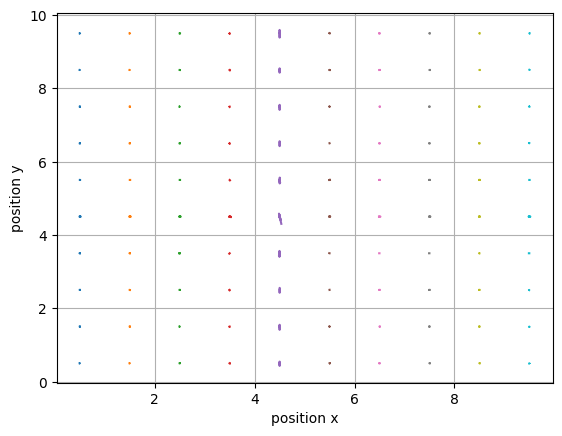

In [107]:
# nice plot of the trajectories
anal.show_traj()

#### Trajectory analysis
Here we can see that most of the energy is transfered along the horizontal and vertical axis of the initially offset particle, ergo the particles on the horizontal line. This makes sense in so far that the connections are most direct in these directions and through those connections a vertical energy transfer is more difficult. This can be seen even better in the next two plots, showing the potential energy of the initially offset particle and one diagonal particle, showing a difference of order three. Additionally for the first particle there is a clear periodicity which gets damped and each peak broadens a tiny bit. Contrary to first thought, this is not due to the periodice boundaries but rather because of the nature of the harmonic oscillators. After the offset, the particles move closer together, resulting in a potential energy of 0, which changes back up for the second peak when the particles are too close together. Remember, we cannot see direction in this plot.

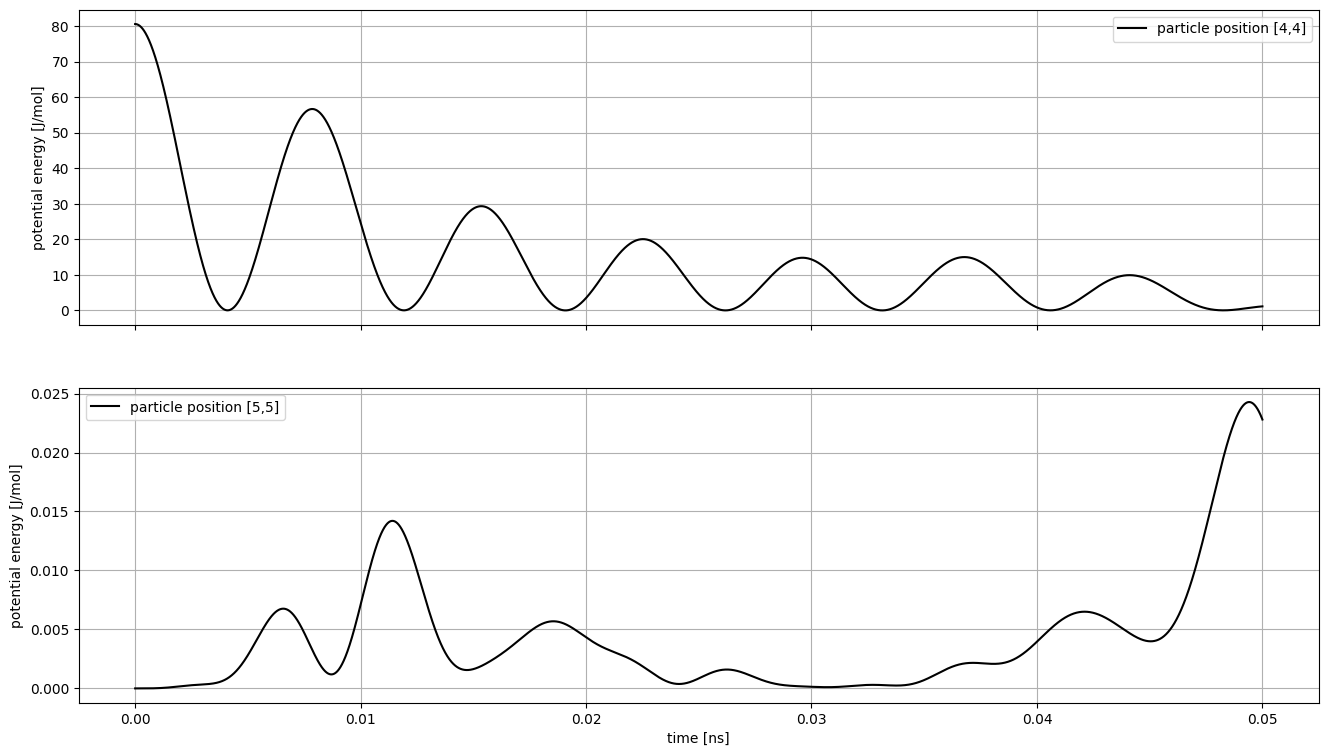

In [43]:
# plotting the potential energy of just one particle over the time steps
time = np.linspace(0,(anal.sim.steps+1)*anal.sim.dt, anal.sim.steps+1)

fig = plt.figure(figsize=(16,9))
axes = fig.subplots(2,1, sharex='col')
axes[0].plot(time,anal.sim.pot_energy[4,4], label='particle position [4,4]', color = 'k')
axes[1].plot(time,anal.sim.pot_energy[5,5], label='particle position [5,5]', color = 'k')

axes[1].set_xlabel('time [ns]')
axes[0].set_ylabel('potential energy [J/mol]')
axes[1].set_ylabel('potential energy [J/mol]')
axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()
plt.show()

#### A heat map of energy transfer
Here is a movie that shows the energy transfer through the grid. Each tile represents the energy of one particle. While initially a clear periodic wave is visible mainly in the middle column, we can see this waive move to its left and right neighbouring column after some time and very minimally (as seen before it has 3 orders of magnitude less). But even there a wave-like behaviour is visible. Please note, that x and y are switched here, which I could not change so far....

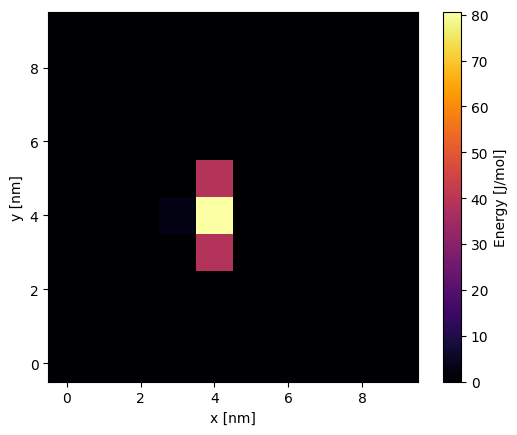

In [15]:
"""Plotting a movie of the energy heat map, while only displaying every nth frame. 
This might be reasonable for performance reasons, since plotting takes 
longer than the simulation... Each tile represents one particle."""
n = 500


data = anal.sim.pot_energy  # Shape (10,10,50001)

# Select every nth frame

frame_indices = np.arange(0, 50000, n)  # [0, 100, 200, ..., 49900]


fig, ax = plt.subplots()
cax = ax.imshow(data[:, :, 0], cmap='inferno', interpolation='nearest', origin='lower')
cbar = fig.colorbar(cax)

ax.set_xlabel("x [nm]")
ax.set_ylabel("y [nm]")
cbar.set_label("Energy [J/mol]")  # Label for colorbar

# Update function for animation
def update(frame_idx):
    cax.set_array(data[:, :, frame_indices[frame_idx]])  # Use selected frames
    return [cax]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(frame_indices), interval=30, blit=False)


HTML(ani.to_jshtml())

#### Simulation with varying coupling
Here we draw the differen $\omega$ from the above mentioned normal distribution. Additionally 10 random connections are set to 0.

In [108]:
# initialize the class
frog2 = Froggy(box_size=np.array([10,10]), rng_seed=421)
# fill the box with particles; properties specified above

# draw the omegas from a random distribution
omega = frog2.rng.normal(1,0.2,size=(2,grid[0],grid[1]))*1000

# Set x percentage of the connections to a weight of 0
x_percentage = 0.1
indices = frog2.rng.choice(2*n_particles, int(x_percentage*2*n_particles), replace=False)  # Pick 10 unique indices
omega.flat[indices] = 0  # Set those indices to True


frog2.fill_particles(n_Particles=n_particles,radius=radius, mass=mass, omega=omega, vel=vel, align='grid', grid=grid)

[0.5 0.5]


In [109]:
# Changing the particle at, the same as in the above simulation
frog2.particles_pos[change_particle_index[0], change_particle_index[1],0] += np.sin(angle)*distance
frog2.particles_pos[change_particle_index[0], change_particle_index[1],1] += np.cos(angle)*distance

In [110]:
# Define the simulation class, passing the box
sim2 = Simulation(frog2, steps, dt = 1e-6)

In [111]:
# run the simulation
sim2.run()

In [112]:
# For analysing the results a Analysis class is used
anal2 = Analysis(sim2)

In [113]:
# reshaping the data_traj for showing the trajectories
anal2.sim.data_traj = anal2.sim.data_traj.reshape(int(np.prod(grid)),3,2,steps+1)

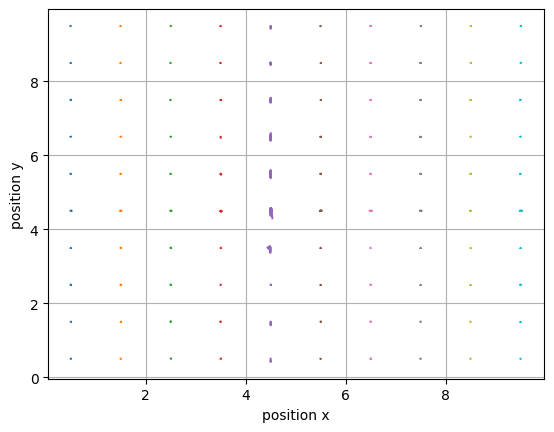

In [114]:
# nice plot
anal2.show_traj()

#### Analysis
Please note that all red curves are concerning task 3, all black curves always refer to task 2 (équal oscillators).
We again take a closer look at the energies of the initially offset particle and its diagonal neighbour. This time, the energy dampens much quicker and is more irregular. The latter is even more visible in the second plot, which still contains some oscillations, but fluctuates far more than in the first experiment. The similarity between both curves is due to the same offset used in both cases, so roughly both energy systems should behave equally, except for the effects of different or missing $\omega$.
One very interesting finding is in the particle at position [0,4], which is on the same axis as the initially moved particle. However in the second run, one of the harmonic oscillators in between directly connecting particles was set to 0. Therefore the energy only arrives much later from the other side. Additionally the peaks are not as defined as in the initial case. However after a while there is an oscillatory motion that starts as well. 
The energy transfer does not seem to be completely diffusive in the second experiment, contrary to a clear ballistic motion in the first experiment. However this might be just a time issue of too few time steps, as discussed and implemented below.

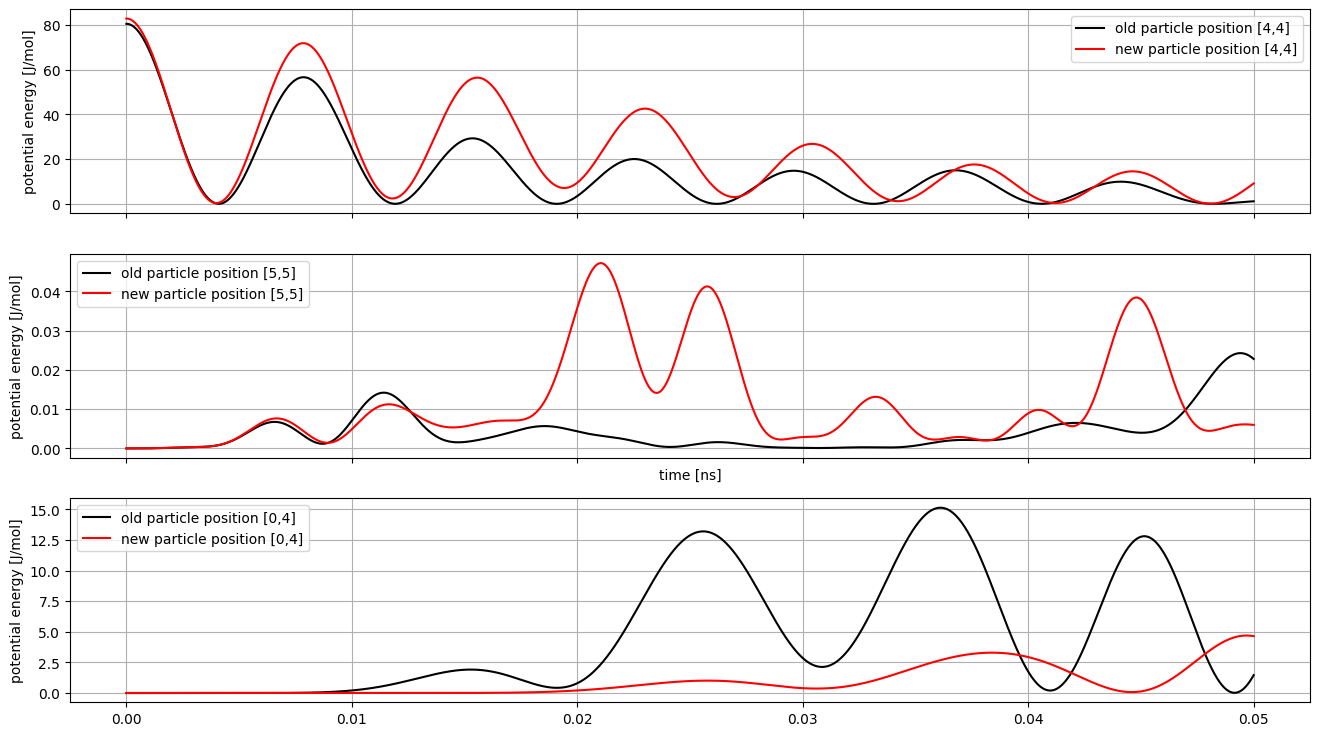

In [ ]:
# plotting the potential energy of just one particle over the time steps
time = np.linspace(0,(anal.sim.steps+1)*anal.sim.dt, anal.sim.steps+1)

fig = plt.figure(figsize=(16,9))
axes = fig.subplots(3,1, sharex='col')
axes[0].plot(time,anal.sim.pot_energy[4,4], label='old particle position [4,4]', color = 'k')
axes[0].plot(time,anal2.sim.pot_energy[4,4], label='new particle position [4,4]', color = 'r')
axes[1].plot(time,anal.sim.pot_energy[5,5], label='old particle position [5,5]', color = 'k')
axes[1].plot(time,anal2.sim.pot_energy[5,5], label='new particle position [5,5]', color = 'r')
axes[2].plot(time,anal.sim.pot_energy[0,4], label='old particle position [0,4]', color = 'k')
axes[2].plot(time,anal2.sim.pot_energy[0,4], label='new particle position [0,4]', color = 'r')

axes[2].set_xlabel('time [ns]')
axes[0].set_ylabel('potential energy [J/mol]')
axes[1].set_ylabel('potential energy [J/mol]')
axes[2].set_ylabel('potential energy [J/mol]')
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.show()

Interestingly in the video we can see that the energy mainly propagates upwards. This is due to the connections downwards being set to zero.

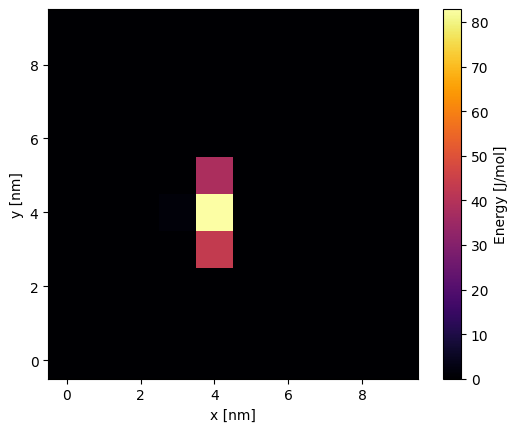

In [24]:
"""Plotting a movie of the energy heat map, while only displaying every nth frame. 
This might be reasonable for performance reasons, since plotting takes 
longer than the simulation... Each tile represents one particle."""
n = 500


data = anal2.sim.pot_energy  # Shape (10,10,50001)

# Select every nth frame

frame_indices = np.arange(0, 50000, n)  # [0, 100, 200, ..., 49900]


fig, ax = plt.subplots()
cax = ax.imshow(data[:, :, 0], cmap='inferno', interpolation='nearest', origin='lower')
cbar = fig.colorbar(cax)

ax.set_xlabel("x [nm]")
ax.set_ylabel("y [nm]")
cbar.set_label("Energy [J/mol]")  # Label for colorbar

# Update function for animation
def update(frame_idx):
    cax.set_array(data[:, :, frame_indices[frame_idx]])  # Use selected frames
    return [cax]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(frame_indices), interval=30, blit=False)


HTML(ani.to_jshtml())

Lastly I wanted to see if the energy transfer settles somewhat. Therefore a simulation of 1000000 steps is performed. Calculating more time steps gets difficult, not due to time constraints (1million time steps take 1min44seconds to calculate) due to memory issues. The trajectories are saved into memory since the results should be analyzed directly, however the data_traj variable for 10million time steps needs ~44gb of RAM and I only have 16 :/


In [56]:
grid            = np.array([10,10], dtype=int) # nm x nm
n_particles     = int(np.prod(grid))

radius  = 0.1   # nm
mass    = 0.02  # kg
omega   = 1000  # J/(mol * nm^2)
vel     = 0     # nm/ns

steps   = 1000000
dt      = 1e-6  # ns




In [57]:
# initialize the class
frog = Froggy(box_size=np.array([10,10]), rng_seed=420)
# fill the box with particles; properties specified above
frog.fill_particles(n_Particles=n_particles,radius=radius, mass=mass, omega=omega, vel=vel, align='grid', grid=grid)

[0.5 0.5]


In [58]:
# defining the offset using the random number generator from the box class for reproducibility
angle = frog.rng.uniform(0,2 * np.pi)
distance = 0.2  # nm

change_particle_index = np.array([4,4])

# Changing the particle at
frog.particles_pos[change_particle_index[0], change_particle_index[1],0] += np.sin(angle)*distance
frog.particles_pos[change_particle_index[0], change_particle_index[1],1] += np.cos(angle)*distance

In [59]:
# Define the simulation class, passing the box
sim = Simulation(frog, steps, dt = 1e-6)

In [60]:
# run the simulation
sim.run()

In [61]:
# For analysing the results a Analysis class is used
anal = Analysis(sim)

In [62]:
# reshaping the data_traj for showing the trajectories
anal.sim.data_traj = anal.sim.data_traj.reshape(n_particles,3,2,steps+1)

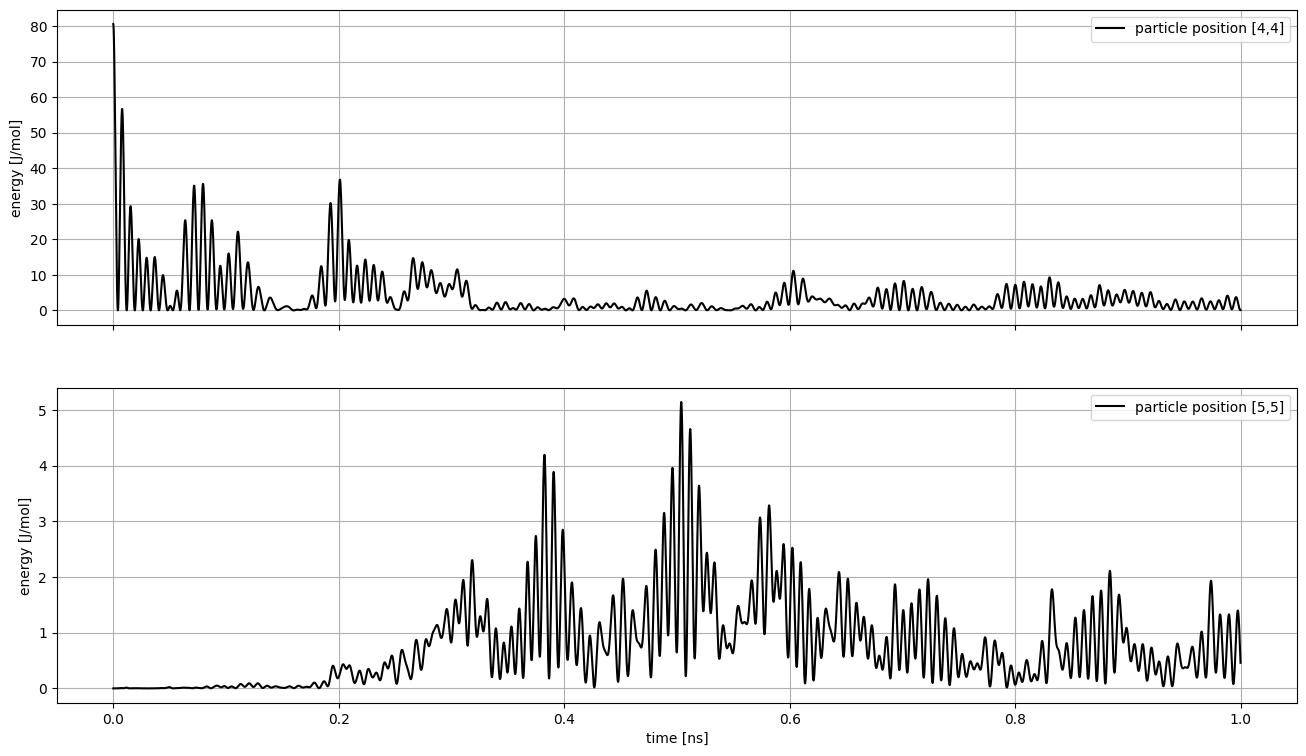

In [32]:
# plotting the potential energy of just one particle over the time steps
time = np.linspace(0,(anal.sim.steps+1)*anal.sim.dt, anal.sim.steps+1)

fig = plt.figure(figsize=(16,9))
axes = fig.subplots(2,1, sharex='col')
axes[0].plot(time,anal.sim.pot_energy[4,4], label='particle position [4,4]', color = 'k')
axes[1].plot(time,anal.sim.pot_energy[5,5], label='particle position [5,5]', color = 'k')

axes[1].set_xlabel('time [ns]')
axes[0].set_ylabel('energy [J/mol]')
axes[1].set_ylabel('energy [J/mol]')
axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()
plt.show()

This time all particles seem to be moving quite a lot and in the energy plots, both particles settle into a similar magnitude of energy. However there are still many oscillations visible. There also seems to be a somehwat larger oscillation engulfing the smaller frequency. This is probably due to the periodic boundary conditions and the energy 'coming' back around to the intial particle.
For further investigation it would be interesting to find out, wether the frequency of these oscillations changes.

In [47]:
# initialize the class
frog2 = Froggy(box_size=np.array([10,10]), rng_seed=421)
# fill the box with particles; properties specified above

# draw the omegas from a random distribution
omega = frog2.rng.normal(1,0.2,size=(2,grid[0],grid[1]))*1000

# Set x percentage of the connections to a weight of 0
x_percentage = 0.1
indices = frog2.rng.choice(2*n_particles, int(x_percentage*2*n_particles), replace=False)  # Pick 10 unique indices
omega.flat[indices] = 0  # Set those indices to True


frog2.fill_particles(n_Particles=n_particles,radius=radius, mass=mass, omega=omega, vel=vel, align='grid', grid=grid)

[0.5 0.5]


In [48]:
# Changing the particle at, the same as in the above simulation
frog2.particles_pos[change_particle_index[0], change_particle_index[1],0] += np.sin(angle)*distance
frog2.particles_pos[change_particle_index[0], change_particle_index[1],1] += np.cos(angle)*distance

In [49]:
# Define the simulation class, passing the box
sim2 = Simulation(frog2, steps, dt = 1e-6)

In [50]:
# run the simulation
sim2.run()

In [51]:
# For analysing the results a Analysis class is used
anal2 = Analysis(sim2)

In [52]:
# reshaping the data_traj for showing the trajectories
anal2.sim.data_traj = anal2.sim.data_traj.reshape(int(np.prod(grid)),3,2,steps+1)

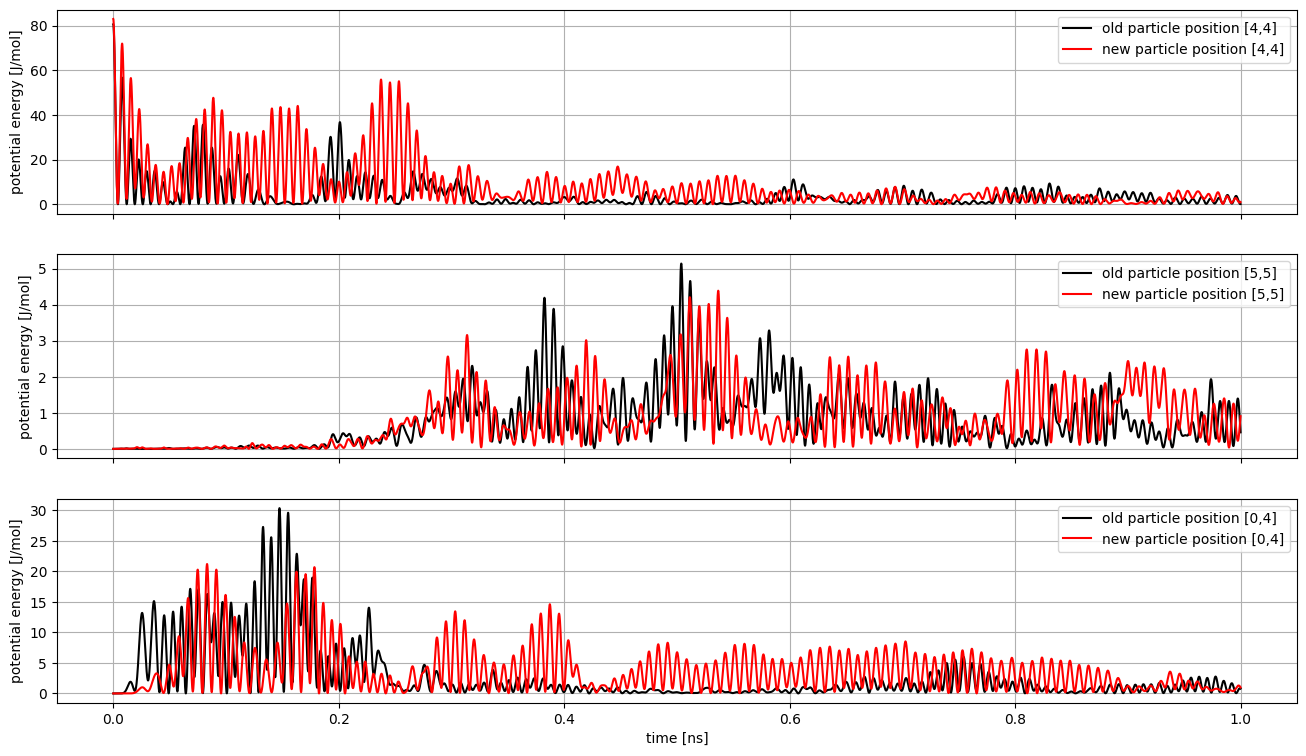

In [64]:
# plotting the potential energy of just one particle over the time steps
time = np.linspace(0,(anal2.sim.steps+1)*anal2.sim.dt, anal2.sim.steps+1)

fig = plt.figure(figsize=(16,9))
axes = fig.subplots(3,1, sharex='col')
axes[0].plot(time,anal.sim.pot_energy[4,4], label='old particle position [4,4]', color = 'k')
axes[0].plot(time,anal2.sim.pot_energy[4,4], label='new particle position [4,4]', color = 'r')
axes[1].plot(time,anal.sim.pot_energy[5,5], label='old particle position [5,5]', color = 'k')
axes[1].plot(time,anal2.sim.pot_energy[5,5], label='new particle position [5,5]', color = 'r')
axes[2].plot(time,anal.sim.pot_energy[0,4], label='old particle position [0,4]', color = 'k')
axes[2].plot(time,anal2.sim.pot_energy[0,4], label='new particle position [0,4]', color = 'r')

axes[2].set_xlabel('time [ns]')
axes[0].set_ylabel('potential energy [J/mol]')
axes[1].set_ylabel('potential energy [J/mol]')
axes[2].set_ylabel('potential energy [J/mol]')
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.show()

Interestingly while the particle (5,5) not on the same axis, as the initial offset particle shows similar behaviour in both cases, both particles on the axis show vastly different outcomes. In the equal oscillator case the energy still fluctuates periodically, but in the second case, there is far greater longterm oscillation of an engulfing frequency. This might be due to some of the particles not connected, but a reasonable, more detailed explanation does not come to mind right now. However in both cases the fluctuations never completely stop, so both systems take a really long time to settle into some sort of stable state.

In a last test, I'll be looking into what changes with double the amount of 'dead' connections

In [115]:
# initialize the class
frog2 = Froggy(box_size=np.array([10,10]), rng_seed=421)
# fill the box with particles; properties specified above

# draw the omegas from a random distribution
omega = frog2.rng.normal(1,0.2,size=(2,grid[0],grid[1]))*1000

# Set x percentage of the connections to a weight of 0
x_percentage = 0.2
indices = frog2.rng.choice(2*n_particles, int(x_percentage*2*n_particles), replace=False)  # Pick 10 unique indices
omega.flat[indices] = 0  # Set those indices to True


frog2.fill_particles(n_Particles=n_particles,radius=radius, mass=mass, omega=omega, vel=vel, align='grid', grid=grid)

[0.5 0.5]


In [116]:
# Changing the particle at, the same as in the above simulation
frog2.particles_pos[change_particle_index[0], change_particle_index[1],0] += np.sin(angle)*distance
frog2.particles_pos[change_particle_index[0], change_particle_index[1],1] += np.cos(angle)*distance

In [117]:
# Define the simulation class, passing the box
sim2 = Simulation(frog2, steps, dt = 1e-6)

In [118]:
# run the simulation
sim2.run()

In [119]:
# For analysing the results a Analysis class is used
anal2 = Analysis(sim2)

In [120]:
# reshaping the data_traj for showing the trajectories
anal2.sim.data_traj = anal2.sim.data_traj.reshape(int(np.prod(grid)),3,2,steps+1)

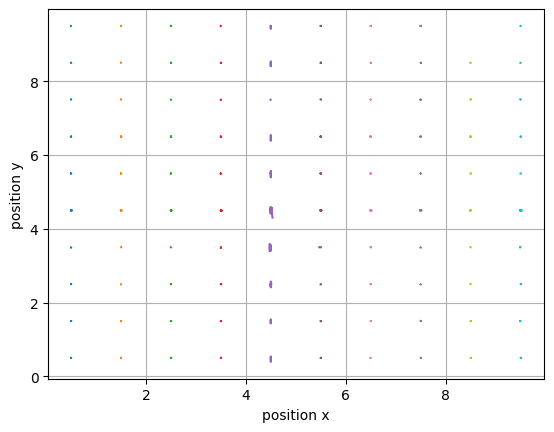

In [121]:
# nice plot
anal2.show_traj()

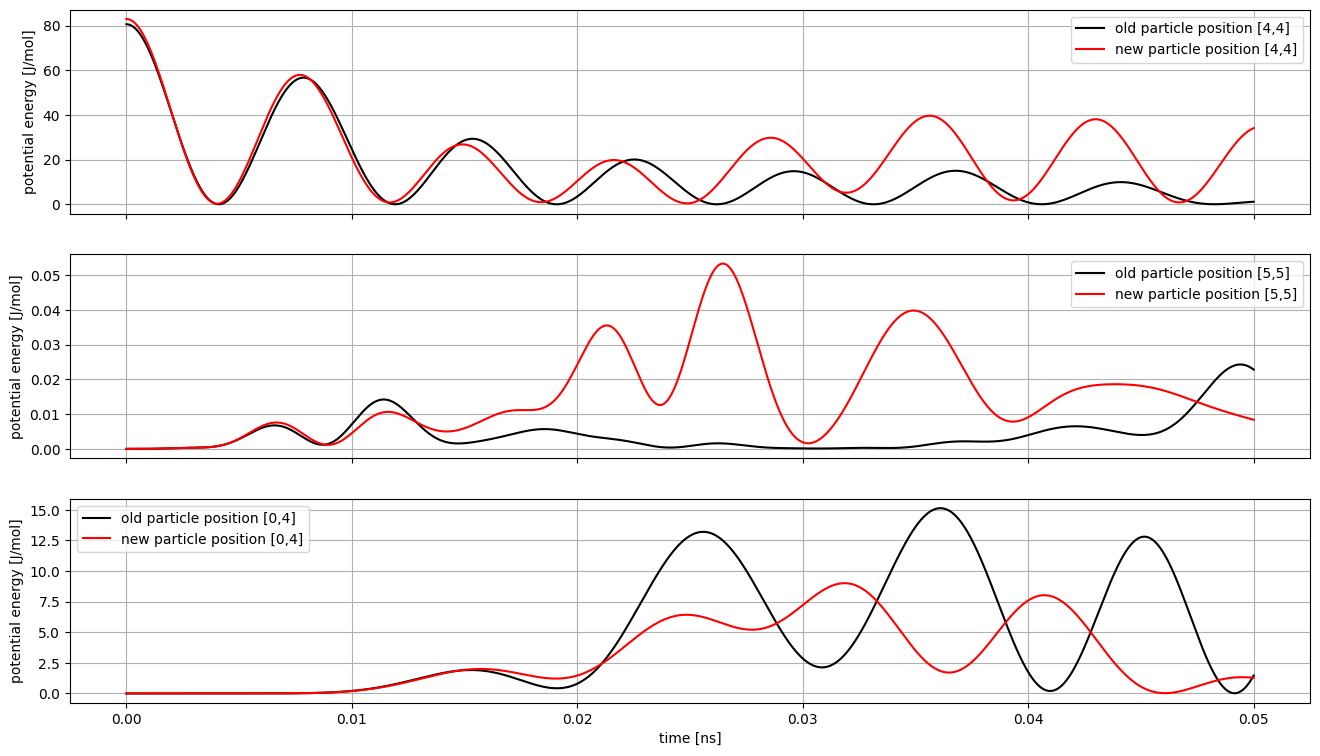

In [98]:
# plotting the potential energy of just one particle over the time steps
time = np.linspace(0,(anal.sim.steps+1)*anal.sim.dt, anal.sim.steps+1)

fig = plt.figure(figsize=(16,9))
axes = fig.subplots(3,1, sharex='col')
axes[0].plot(time,anal.sim.pot_energy[4,4], label='old particle position [4,4]', color = 'k')
axes[0].plot(time,anal2.sim.pot_energy[4,4], label='new particle position [4,4]', color = 'r')
axes[1].plot(time,anal.sim.pot_energy[5,5], label='old particle position [5,5]', color = 'k')
axes[1].plot(time,anal2.sim.pot_energy[5,5], label='new particle position [5,5]', color = 'r')
axes[2].plot(time,anal.sim.pot_energy[0,4], label='old particle position [0,4]', color = 'k')
axes[2].plot(time,anal2.sim.pot_energy[0,4], label='new particle position [0,4]', color = 'r')

axes[2].set_xlabel('time [ns]')
axes[0].set_ylabel('potential energy [J/mol]')
axes[1].set_ylabel('potential energy [J/mol]')
axes[2].set_ylabel('potential energy [J/mol]')
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.show()

On a first glance, there does not seem to be something unforeseeable happening. The system behaves qualitatively similar to the case with only 10\% dead connections, even though the individual trajectories obviously differ due to other connections being removed. However there is no quicker diffusion visible.

#### performance tests
Initially I had the algorithm calculate the distances between neighbouring particles written using the np.roll() function. But after performing the following test, where np.diff() performed faster for all sizes of arrays, I switched the method. It is interesting however, that for larger arrays (meaning more particles) the times equal out.

In [33]:
import numpy as np
import timeit

# Indexing-only method (without np.roll)
def compute_distances_indexing(positions):
    # rechts, unten?
    distances = np.array([np.diff(positions, append=positions[:,0, np.newaxis,:], axis=1), 
                              np.diff(positions, append=positions[0, np.newaxis,:,:], axis=0)])#%self.box_size

    return distances

# np.roll() method
def compute_distances_roll(positions):
    # unten, rechts?
    distances = (np.array([np.roll(positions,-1,axis=0),np.roll(positions,-1,axis=1)])-positions)


    return distances

# Define test sizes
sizes = [10,25,50,100]
results = {}

# Run benchmark
for size in sizes:
    positions = np.random.rand(size, size, 2)  # Generate random particle positions

    time_indexing = timeit.timeit(lambda: compute_distances_indexing(positions), number=10000)
    time_roll = timeit.timeit(lambda: compute_distances_roll(positions), number=10000)

    results[size] = {"indexing": time_indexing, "roll": time_roll}

results

{10: {'indexing': 0.1231666998937726, 'roll': 0.14035580004565418},
 25: {'indexing': 0.10843969997949898, 'roll': 0.16524499980732799},
 50: {'indexing': 0.20327249984256923, 'roll': 0.22884300001896918},
 100: {'indexing': 0.4047018999699503, 'roll': 0.39432920003309846}}